# Big Data Derby 2022
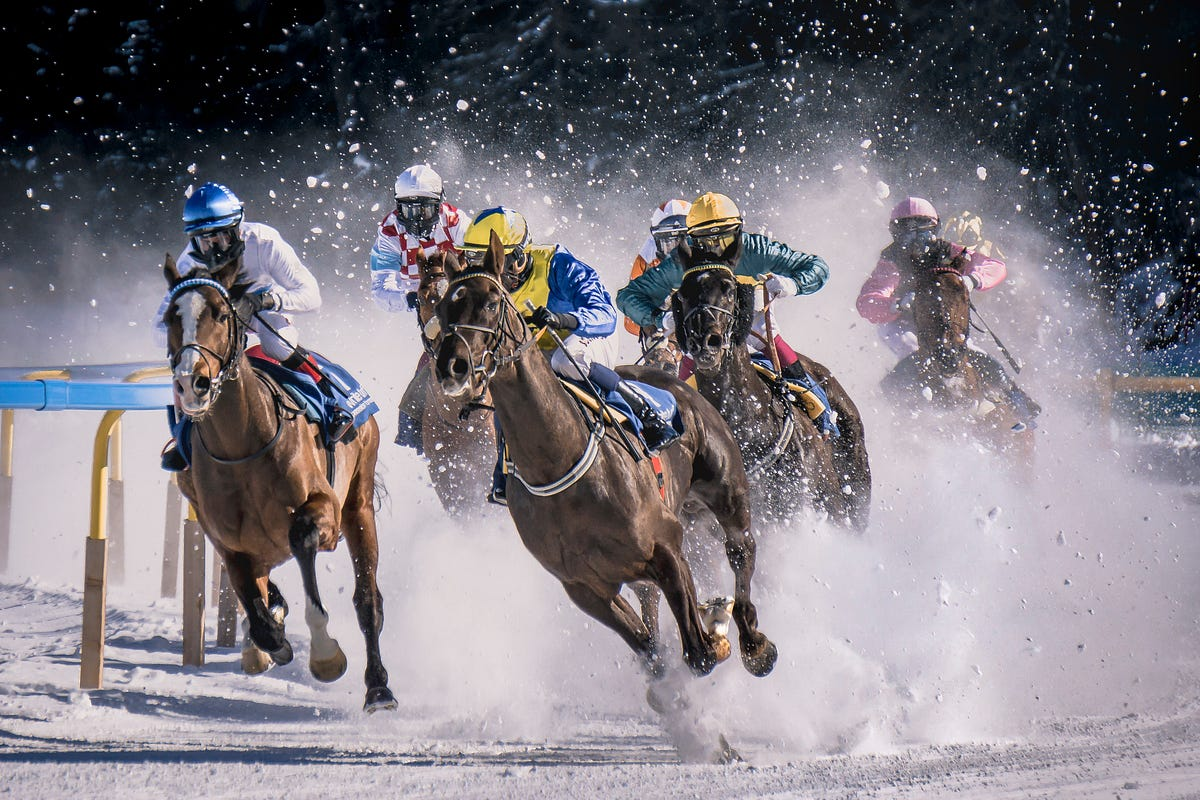

## 1. 대회 설명

### 1-1. 목적
- 경마 추적 데이터를 활용하여 **레이싱 전략**, **초안 전략**, **경로 효율성 등**을 분석하는 모델 개발
- 참가자는 자유롭게 주제를 설정할 수 있으며, 주제의 예시는 다음과 같음 :
    1. **말 성과 평가 모델 개발**
        - 기대 순위와 실제 순위를 비교하여 성과를 평가.
        - 경주 중 기대 순위 변화 분석.
        - 성과 지표가 경쟁자의 위치에 영향을 받는지 확인.
    2. **최적의 레이싱 전략 도출**
        - 경주장, 트랙 유형, 경주 거리별 최적의 레이싱 전략 분석.
        - 기수의 경로 효율성을 기준으로 한 기수 평가 지표 생성.
    3. **트랙 공정성 모델 개발**
        - 특정 경로가 순위에 미치는 유리/불리한 영향을 평가.
        - 기상 조건, 기압, 유지보수 요인 등 숨겨진 변수 분석.

### 1-2. 데이터
- **nyra_start_table.csv** - 말/기수의 경주 관련 데이터
    - `track_id`: 경주 트랙 ID (AQU, BEL, SAR).
    - `race_date`: 경주 날짜 (YYYY-MM-DD).
    - `race_number`: 경주 번호 (숫자로 변환 가능).
    - `program_number`: 경주 중 말의 고유 번호.
    - `weight_carried`: 말이 경주 중 실은 무게 (kg).
    - `jockey`: 기수 이름.
    - `odds`: 경주 우승 배당률 (숫자를 100으로 나눠 활용).
    - `position_at_finish`: 경주 완료 순위.
- **nyra_race_table.csv** - 경주 트랙 정보
    - `track_id`: 경주 트랙 ID (AQU, BEL, SAR).
    - `race_date`: 경주 날짜 (YYYY-MM-DD).
    - `race_number`: 경주 번호 (숫자로 변환 가능).
    - `distance_id`: 경주 거리 (퍼롱 단위).
    - `course_type`: 경주 코스 유형 (예: M - 허들, D - 흙, O - 외부 잔디).
    - `track_condition`: 트랙 상태 (예: YL - Yielding, FM - Firm).
    - `run_up_distance`: 출발 게이트에서 경주 시작 지점까지의 거리 (피트 단위).
    - `race_type`: 경주 분류 (예: STK - Stakes, CLM - Claiming).
    - `purse`: 상금 (USD).
    - `post_time`: 경주 시작 시간 (5자리, 예: 01220 → 12:20).
- **nyra_tracking_table.csv** - 말의 위치 추적 데이터
    - `track_id`: 경주 트랙 ID (AQU, BEL, SAR).
    - `race_date`: 경주 날짜 (YYYY-MM-DD).
    - `race_number`: 경주 번호 (숫자로 변환 가능).
    - `program_number`: 말의 고유 번호.
    - `trakus_index`: 좌표 측정 지점 (0.25초 단위).
    - `latitude`, `longitude`: 좌표 데이터.
- **nyra_2019_complete.csv** - 위 3개 데이터 통합 버전

## 2. 수상작 설명 

### 2-1. 목적
- 경주 트랙과 다양한 경주의 특성을 분석
- 말의 성능을 평가하고, 말이 마라토너인지 스프린터인지 식별

## 3. 데이터 전처리

### 3-1. Library

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from tqdm import tqdm
import re
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

### 3-2. 원본 데이터 로드

**🏷️ complete_table** : 데이터 통합본
<br>
**🏷️ start_table** : 말/기수의 경주 관련 데이터
<br>
**🏷️ race_table** : 경주 트랙 정보
<br>
**🏷️ tracking_table** : 말의 위치 추적 데이터

#### 📍 컬럼 어레인지

In [2]:
complete_table = pd.read_csv('./Data/nyra_2019_complete.csv')

"""
nyra_2019_complete.csv는 첫번째 행이 컬럼으로 지정되어 있음
임시 DF를 생성하여 기존 컬럼을 첫번째 행으로 빼고
컬럼명을 재 정의한 후, 다시 통합하여 데이터 준비 
"""

# 1. 임시 DF 생성 및 컬럼명 숫자로 초기화 
d = pd.DataFrame(columns = range(len(list(complete_table.columns))))

# 2. 기존 컬럼을 첫번째 행으로 빼기
d.loc[0] = list(complete_table.columns)

# 3. 컬럼명 재정의
complete_table.columns = ['track_id', 'race_date', 'race_number', 'program_number', 'trakus_index',
                         'latitude', 'longitude', 'distance_id', 'course_type', 'track_condition',
                         'run_up_distance', 'race_type', 'purse', 'post_time', 'weight_carried',
                          'jockey', 'odds', 'position_at_finish']
d.columns = ['track_id','race_date','race_number','program_number','trakus_index',
             'latitude','longitude','distance_id','course_type','track_condition',
             'run_up_distance','race_type','purse','post_time','weight_carried',
             'jockey','odds','position_at_finish']

# 4. 두 DF 통합
complete_table = pd.concat([d, complete_table])

In [3]:
complete_table.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,9,6,72,40.6729017197787,-73.8276065972899,600,D,GD,48,CLM,25000.00,00420,120,Andre Shivnarine Worrie,2090,8
0,AQU,2019-01-01,9,6,73,40.67,-73.83,600,D,GD,48,CLM,25000.00,420,120,Andre Shivnarine Worrie,2090,8
1,AQU,2019-01-01,9,6,74,40.67,-73.83,600,D,GD,48,CLM,25000.00,420,120,Andre Shivnarine Worrie,2090,8
2,AQU,2019-01-01,9,6,63,40.67,-73.83,600,D,GD,48,CLM,25000.00,420,120,Andre Shivnarine Worrie,2090,8
3,AQU,2019-01-01,9,6,64,40.67,-73.83,600,D,GD,48,CLM,25000.00,420,120,Andre Shivnarine Worrie,2090,8


In [4]:
start_table = pd.read_csv('./Data/nyra_start_table.csv')
start_table.columns = ['track_id','race_date','race_number','program_number','weight_carried','jockey','odds','position_at_finish']
race_table = pd.read_csv('./Data/nyra_race_table.csv')
tracking_table = pd.read_csv('./Data/nyra_tracking_table.csv')

In [5]:
for name, table in zip(['start_table', 'race_table', 'tracking_table'], 
                       [start_table.head(2), race_table.head(2), tracking_table.head(2)]):
    print(f"\n{name}:\n", table)


start_table:
   track_id   race_date  race_number program_number  weight_carried  \
0      AQU  2019-01-01            1            2               120   
1      AQU  2019-01-01            1            3               118   

            jockey  odds  position_at_finish  
0  Junior Alvarado   295                   3  
1     Jose Lezcano   180                   4  

race_table:
   track_id   race_date  race_number  distance_id course_type track_condition  \
0      AQU  2019-01-01            1          650           D             MY    
1      AQU  2019-01-01            2          600           D             MY    

   run_up_distance race_type  purse  post_time  
0               36       AOC  80000       1220  
1               48       MCL  41000       1250  

tracking_table:
   track_id   race_date  race_number program_number  trakus_index  latitude  \
0      AQU  2019-01-01            9            6              72     40.67   
1      AQU  2019-01-01            9            6         

### 3-3. 데이터 타입 변환 및 데이터 사이즈 축소

#### **🏷️ complete_table**

**ASIS**
- object 타입으로만 구성되어 있음
- 797.8MB 

**TOBE**
- **숫자형 변수**
    - 고유 값의 개수, 가장 높은 값과 가장 낮은 값을 확인 
      *(코드에는 나와있지 않지만 .unique() 등을 통해 확인했을 것으로 추정)*
    - 해당 정보를 바탕으로 int8, int16, float16 등의 데이터 타입으로 변환
        - int8: -128부터 127까지의 정수 저장 가능
        - int16: -32,768부터 32,767까지의 정수 저장 가능
        - float16: 숫자 범위가 더 넓고 소수점까지 표현 가능
- **날짜형 변수**
    - post_time
        - `%H:%M` 형식으로 변환
        - `%Y-%m-%d` (race_date)의 날짜를 결합
        - 최종적으로 `%H:%M %Y-%m-%d` 완성
    - race_date
        - `%Y-%m-%d` 형식으로 변환
- **텍스트 변수**
    - 텍스트 데이터를 라벨 인코딩(Label Encoding)하여 숫자 데이터로 변환
    - 레이블 인코딩 변환 결과는 딕셔너리에 저장하여, 인코딩된 값과 원래 값을 확인할 수 있도록 진행

In [6]:
complete_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5228430 entries, 0 to 5228428
Data columns (total 18 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   track_id            object
 1   race_date           object
 2   race_number         object
 3   program_number      object
 4   trakus_index        object
 5   latitude            object
 6   longitude           object
 7   distance_id         object
 8   course_type         object
 9   track_condition     object
 10  run_up_distance     object
 11  race_type           object
 12  purse               object
 13  post_time           object
 14  weight_carried      object
 15  jockey              object
 16  odds                object
 17  position_at_finish  object
dtypes: object(18)
memory usage: 757.9+ MB


#### 📍 숫자형 변수로의 변환

각 변수의 가장 높은 값과 가장 낮은 값을 확인하여 사이즈를 가늠한 후, 이를 바탕으로 int8, int16 등 적절한 숫자형 데이터 타입을 지정하는 방식이다. 데이터 타입을 지정할 때 이러한 기준을 가지고 지정한다는 점에서 디테일을 발견할 수 있었다. 

In [7]:
# 숫자형 변수



"""
1. race_number
"""
complete_table['race_number'] = complete_table['race_number'].astype('int8')



"""
2. program_number (예: 6, 1A, 2B 등)

> 이 부분은 개선이 필요하거나 or 불필요한것 같다. 
> 코드를 실행해도 원래의 datatype인 object로 유지됨.
> 숫자형으로 변환하려는 목적에서 이 코드를 작성한게 아닌지?

> 현재 코드 로직 : 
  - 숫자만 포함된 값들은 int 타입으로 변환하고
  - 문자가 같이 결합된 값들은 원래 형태 그대로 유지

> 개선이 필요한 부분 : 
  - 문자가 포함된 경우에도 해당 문자열을 유효한 값으로 변환할 수 있는 추가적인 처리가 필요
  - 예시 1) 1A와 같은 값은 동일하게 1로 처리 (다만, 1A가 1이랑 똑같이 취급되도 괜찮은 건지 데이터의 의미에 맞게 결정 필요)
  - 예시 2) 1A를 1과 구분 짓기 위해 별도의 숫자 지정 (1A->11) (다만, 중복을 방지하기 위하여 데이터를 파악 후, 의미있는 숫자 부여가 필요)
"""
# 미리 컴파일해서 패턴 지정 (하나 이상의 숫자)
r1 = re.compile('\d+')   

# 주어진 값이 문자열인지 확인 (True or False)
is_string = lambda x : type(x) == str

# 문자열인 경우, 공백을 기준으로 분할한 후 첫번째 값을 선택 (예: "1 A" -> "1")
l1 = [i.split()[0] if type(i) == str else i for i in tqdm(list(complete_table['program_number']))]

# 정규식으로 숫자 추출 및 조건에 맞는 값만 필터링
l2 = []
for i in tqdm(l1):
    if is_string(i) == True:
        try:
            if int(r1.findall(i)[0]) == int(i):   # 숫자를 찾고, 그 숫자가 정수(i)와 같다면 l2에 추가
                l2.append(int(r1.findall(i)[0]))
        except ValueError:
            l2.append(i)
    else:
        l2.append(i)

# 저장
complete_table['program_number'] = l2



"""
3. trakus_index (예: 72, 1043 등)
"""
complete_table['trakus_index'] = complete_table['trakus_index'].astype('int16')


"""
4. latitude, longitude (예: 40.6729017197787 등)
"""
complete_table['latitude'] = complete_table['latitude'].astype('float16')
complete_table['longitude'] = complete_table['longitude'].astype('float16')


"""
5. distance_id, run_up_distance (예: 1400, 182)
"""
complete_table['distance_id'] = complete_table['distance_id'].astype('int16')
complete_table['run_up_distance'] = complete_table['run_up_distance'].astype('int16')


"""
6. purse (예: 25000.00)
- 소수점을 정확히 처리하기 위해 1)float 변환 -> 2)int32 변환 
"""
complete_table['purse'] = complete_table['purse'].astype(float)
complete_table['purse'] = complete_table['purse'].astype('int32')


"""
7. weight_carried (예: 120)
8. odds (예: 1210)
9. position_at_finish (예: 8)
"""
complete_table['weight_carried'] = complete_table['weight_carried'].astype('int8')
complete_table['odds'] = complete_table['odds'].astype('int16')
complete_table['position_at_finish'] = complete_table['position_at_finish'].astype('int8')

100%|████████████████████████████| 5228430/5228430 [00:01<00:00, 3043979.36it/s]


#### 📍 날짜형 변수로의 변환

날짜로 사용하려는 변수는 시간과 초를 나타내는 'post_time' 컬럼과, 연-월-시를 나타내는 'race_date'에 적용하였다.

시간과 초를 나타내는 'post_time' 컬럼의 경우, '900', '1230' 등의 형태를

1) %H:%M 형식으로 변환

2) 연-월-시를 나타내는  'race_date' 의 데이터와 결합하여

최종적으로 '**%H:%M  %Y-%m-%d'** 의 날짜 타입으로 완성 시킨다.

연-월-시를 나타내는 'race_date'의 경우, 따로 전처리는 하지 않고 datetime 형식으로만 맞춰주었다.

In [73]:
# 날짜형 변수

"""
# 1. post_time - 시:분 형식의 시간과 'race_date'의 날짜를 결합하여 datetime 형식으로 변환
# 2. race_date - datetime 형식으로 변환.
"""

# post_time str로 변환
complete_table['post_time'] = complete_table['post_time'].astype(str)

# 저장 객체 생성
l1 = list(complete_table['post_time']);
l2 = list(complete_table['race_date'])

# post_time 값의 길이에 따라 다른 방식으로 처리 
l = []
for i,j in tqdm(zip(l1,l2)):
    # 예) 900 -> 9:00 2019-01-01
    if len(i) == 3:
        l.append(i[:1] + ':' + i[1:] + ' ' + j)
    # 예) 1230 -> 12:30 2019-01-01
    elif len(i) == 4:
        l.append(i[:2] + ':' + i[2:] + ' ' + j)
    # 예) 00420 -> 4:20 2019-01-01
    elif len(i) == 5:
        l.append(i[1:3] + ':' + i[3:] + ' ' + j)  

# 시간(시:분)과 날짜(연도-월-일)가 결합된 datetime 객체로 변환
l = pd.to_datetime(pd.Series(l),format = '%H:%M %Y-%m-%d')
complete_table['post_time'] = l


# 날짜 변환을 위한 딕셔너리 생성
date_dict = dict(zip(pd.date_range("2019-01-01", "2019-12-31").strftime("%Y-%m-%d"),
                     pd.date_range("2019-01-01", "2019-12-31")))

# race_date 매핑
complete_table['race_date'] = complete_table.race_date.map(date_dict)


0it [00:00, ?it/s]
399811it [00:00, 3997923.18it/s]
841159it [00:00, 4242282.75it/s]
1287698it [00:00, 4344072.85it/s]
1735669it [00:00, 4397534.32it/s]
2182514it [00:00, 4423024.18it/s]
2629865it [00:00, 4440118.33it/s]
3075556it [00:00, 4445546.76it/s]
3524222it [00:00, 4458582.07it/s]
3972263it [00:00, 4465333.72it/s]
4420167it [00:01, 4469536.71it/s]
5228430it [00:01, 4425117.35it/s]


#### 📍 텍스트 변수 변환

텍스트 변수의 경우 라벨 인코딩(Label Encoding)을 진행하여 숫자 데이터로 변환하였다.

또한, 레이블 인코딩 변환 결과는 딕셔너리에 저장하여, 인코딩된 값과 원래 값을 확인할 수 있도록 진행한다.

사실, 이렇게 텍스트 변수를 굳이 라벨 인코딩하는 것을 보고, 추후 모델링을 하겠지(?)라고 생각했지만.. EDA만 진행하셨다.

그렇다면 왜 굳이 이런 방식을 선택했을까?

여러 이유를 생각해 보았지만, 가장 유력한 이유는 이러할 것 같다 :  

1. **메모리 최적화**:
    
    텍스트 데이터는 메모리를 많이 차지한다. 이를 숫자로 변환하여 메모리 사용량을 줄이고, 데이터 처리 성능을 최적화한다. 
    
2. **배치 작업:**
    
    실제 현업에서의 상황이라고 가정한다면, 데이터를 쌓을 때마다 실시간으로 인코딩을 진행하는 것은 리소스 낭비가 크다. 
    
    기존 데이터를 인코딩 해둔다면, 새로운 데이터에 대해서는 기존 라벨 인코딩 기준에 맞춰서만 인코딩을 적용하면 된다.
    
    이렇게 새로운 값만 업데이트하면 되므로 처리 속도가 빠르고 일관성을 유지할 수 있다.

In [74]:
# 텍스트 변수 - Label Encoding 진행

le = LabelEncoder()
text_data_features = ['track_id', 'course_type', 'track_condition', 'race_type', 'jockey']

l3 = [] # 인코딩값
l4 = [] # 원래 텍스트 값

print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    # 고유한 텍스트 값을 숫자로 변환
    complete_table[i] = le.fit_transform(complete_table[i])
    # 변환된 고유한 숫자 값들을 저장
    l3.append(list(complete_table[i].unique()))
    # 숫자 값을 다시 원래의 텍스트 값으로 변환 및 저장
    l4.append(list(le.inverse_transform(complete_table[i].unique())))
# 각 텍스트 데이터 특징에 대해, 변환된 고유 값과 원래 텍스트 값을 출력
print(i,' : ',complete_table[i].unique(),' = ',le.inverse_transform(complete_table[i].unique()))

Label Encoder Transformation



100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]

jockey  :  [  5 119  42  66 149  65  79 139 140  95 154 103  60  68 170  18  64  50
 134  85  77  21 124 138 117  89  96 115 148  37 106 146  49  34 141 150
 125 102 105  63 118  76  82 145  39  71 167  75 176  92  26 177  78 136
  57 110 101  23  87 133 153 107 171  81  48  67 127  51  22  29  30  41
  88 175 126 159 132  27  45  53 108  94 104 100 135  73  52  19  93 109
  43 112  46 168  69  59  84 164 166 142   1 157  16  32 120  80  24  83
  56  11  54 143 121 165 111 160  13 174   4  98  90  62 116  58 129 162
  36  74   7  25  47   0  15 155 152   8 113  31 169   9   2 122 131  40
  35  55 173  97  70  72   3 144  86  14 151 130  91  20  10  33 128  12
 172 114  61  44  38  28 123 137 158 161  17  99   6 156 147 163]  =  ['Andre Shivnarine Worrie' 'Manuel Franco' 'Dylan Davis' 'Irad Ortiz Jr.'
 'Samuel Jimenez' 'Heman K. Harkie' 'Joey R. Martinez' 'Rajiv Maragh'
 'Reylu Gutierrez' 'Jose L. Ortiz' 'Silvestre Gonzalez' 'Junior Alvarado'
 'Gerard Galligan' 'Jack Doyle' 'Victor R. C

In [75]:
# 텍스트 변수 - 숫자로 변환된 값과 원래의 텍스트 값 딕셔너리로 관계 저장
# 예) track_id': {0: 'A', 1: 'B', 2: 'C'}

tf1 = {}
for i in range(len(text_data_features)):
    tf1[text_data_features[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf1[text_data_features[i]][j] = k

In [76]:
complete_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5228430 entries, 0 to 5228428
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   track_id            int64         
 1   race_date           datetime64[ns]
 2   race_number         int8          
 3   program_number      object        
 4   trakus_index        int16         
 5   latitude            float16       
 6   longitude           float16       
 7   distance_id         int16         
 8   course_type         int64         
 9   track_condition     int64         
 10  run_up_distance     int16         
 11  race_type           int64         
 12  purse               int32         
 13  post_time           datetime64[ns]
 14  weight_carried      int8          
 15  jockey              int64         
 16  odds                int16         
 17  position_at_finish  int8          
dtypes: datetime64[ns](2), float16(2), int16(4), int32(1), int64(5), int8(3), object(1)
memo

#### 📍 변환한 데이터 Pickle 파일로 저장 (재사용 목적)

이렇게 변환한 데이터를 파일 형태가 아닌, 파이썬 객체 자체로 저장 할 수 있는 Pickle 을 사용하여,

추후 데이터를 다시 불러오고 재사용 할 때 속도를 빠르게 하고, 사이즈도 최적화 할 수 있게 진행하였다.

In [88]:
complete_table.to_pickle('complete_table'  '.pkl', compression = 'gzip')
with open('tf1.pkl','wb') as f:
    pickle.dump(tf1,f)

#### **🏷️ race_table**
= 동일하게 적용

In [78]:
# 숫자형 변수

race_table['race_number'] = race_table['race_number'].astype('int8') 
race_table['distance_id'] = race_table['distance_id'].astype('int16') 
race_table['run_up_distance'] = race_table['run_up_distance'].astype('int16') 
race_table['purse'] = race_table['purse'].astype(float); race_table['purse'] = race_table['purse'].astype('int32') 

In [79]:
# 날짜형 변수

race_table['post_time'] = race_table['post_time'].astype(str) 
l1 = list(race_table['post_time']);
l2 = list(race_table['race_date']) 

l = []
for i,j in tqdm(zip(l1,l2)):
    if len(i) == 3:
        l.append(i[:1] + ':' + i[1:] + ' ' + j)
    elif len(i) == 4:
        l.append(i[:2] + ':' + i[2:] + ' ' + j)
    elif len(i) == 5:
        l.append(i[1:3] + ':' + i[3:] + ' ' + j) 
l = pd.to_datetime(pd.Series(l),format = '%H:%M %Y-%m-%d')
race_table['post_time'] = l

date_dict = dict(zip(pd.date_range("2019-01-01", "2019-12-31").strftime("%Y-%m-%d"),
                     pd.date_range("2019-01-01", "2019-12-31")))

race_table['race_date'] = race_table.race_date.map(date_dict) 


2000it [00:00, 2972575.48it/s]


In [80]:
# 텍스트 변수 - Label Encoding

le = LabelEncoder()
text_data_features = ['track_id', 'course_type', 'track_condition', 'race_type']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    race_table[i] = le.fit_transform(race_table[i])
    l3.append(list(race_table[i].unique())); l4.append(list(le.inverse_transform(race_table[i].unique())))
    print(i,' : ',race_table[i].unique(),' = ',le.inverse_transform(race_table[i].unique()))

Label Encoder Transformation



100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 443.31it/s]

track_id  :  [0 1 2]  =  ['AQU' 'BEL' 'SAR']
course_type  :  [0 3 4 1 2]  =  ['D' 'O' 'T' 'I' 'M']
track_condition  :  [3 2 1 5 0 6 4]  =  ['MY ' 'GD ' 'FT ' 'SY ' 'FM ' 'YL ' 'SF ']
race_type  :  [ 1  3  0  8  2  4  9  6  5 10  7 11]  =  ['AOC' 'MCL' 'ALW' 'STK' 'CLM' 'MSW' 'STR' 'SOC' 'SHP' 'WCL' 'SST' 'WMC']


In [81]:
# 텍스트 변수 - 인코딩된 값 & 원래 텍스트 값 딕셔너리로 묶음

tf2 = {}
for i in range(len(text_data_features)):
    tf2[text_data_features[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf2[text_data_features[i]][j] = k

In [82]:
# 피클 저장
race_table.to_pickle('race_table' + '.pkl',compression = 'gzip' )
with open('tf2.pkl','wb') as f:
    pickle.dump(tf2,f)

#### **🏷️ start_table**
= 동일하게 적용

In [83]:
# 숫자형 변수

start_table['race_number'] = start_table['race_number'].astype('int8') 

r1 = re.compile('\d+'); is_string = lambda x : type(x) == str  
l1 = [i.split()[0] if type(i) == str else i for i in tqdm(list(start_table['program_number']))] ; l2 = []
for i in tqdm(l1):
    if is_string(i) == True:
        try:
            if int(r1.findall(i)[0]) == int(i):
                l2.append(int(r1.findall(i)[0]))
        except ValueError:
            l2.append(i)
    else :
        l2.append(i)
start_table['program_number'] = l2 
start_table['weight_carried'] = start_table['weight_carried'].astype('int8')
start_table['odds'] = start_table['odds'].astype('int16') 
start_table['position_at_finish'] = start_table['position_at_finish'].astype('int8')


100%|████████████████████████████████| 14914/14914 [00:00<00:00, 2294038.79it/s]

100%|████████████████████████████████| 14914/14914 [00:00<00:00, 1194550.85it/s]


In [84]:
# 날짜형 변수

date_dict = dict(zip(pd.date_range("2019-01-01", "2019-12-31").strftime("%Y-%m-%d"),
                     pd.date_range("2019-01-01", "2019-12-31")))

start_table['race_date'] = start_table.race_date.map(date_dict)

In [85]:
# 텍스트 변수 - Label Encoding

le = LabelEncoder()
text_data_features = ['track_id', 'jockey']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    start_table[i] = le.fit_transform(start_table[i])
    l3.append(list(start_table[i].unique())); l4.append(list(le.inverse_transform(start_table[i].unique())))
    print(i,' : ',start_table[i].unique(),' = ',le.inverse_transform(start_table[i].unique()))

Label Encoder Transformation



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 174.60it/s]

track_id  :  [0 1 2]  =  ['AQU' 'BEL' 'SAR']
jockey  :  [103  96  83 119  18  42   5 140  50 139 117  82  56  85  63  78  79 102
 124  64 135  29  65  87  34  43  39 149 138 153  45 107  25  46 115 159
  21 146  32 148 168  58  35 134 154  67 177 166   0 100  13 129  62 142
 110 106  11  71   3 127   4  72   2 131 174  31  49 170 104  51  75  66
  76  95 133 169  57  59  36 144   9 118  41 162 105 164  88  77   8  52
  22  27 172 171  55  92 157  44  40  80 112  81 167 176 116  97  33 143
  84   1 123  54 173 165 141  30  53 152  12 120  17  99 151 101 113  28
  24  47   7 130 126 128 158  98  70 156 163 160  61  60 109  68 150 125
 175 145 137  19 161  89  10  23  93  74 132 111  94  26  37  38 108  16
 147  86  48 136  73  15 121  69  14   6 114  90  91 155 122  20]  =  ['Junior Alvarado' 'Jose Lezcano' 'Jomar Garcia' 'Manuel Franco'
 'Benjamin Hernandez' 'Dylan Davis' 'Andre Shivnarine Worrie'
 'Reylu Gutierrez' 'Eric Cancel' 'Rajiv Maragh' 'Luis R. Reyes'
 'John R. Velazquez' 'Fran

In [86]:
# 텍스트 변수 - 인코딩된 값 & 원래 텍스트 값 딕셔너리로 묶음

tf3 = {}
for i in range(len(text_data_features)):
    tf3[text_data_features[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf3[text_data_features[i]][j] = k

In [87]:
# 피클 저장

start_table.to_pickle('start_table' + '.pkl',compression = 'gzip' )
with open('tf3.pkl','wb') as f:
    pickle.dump(tf3,f)

### 3-4. 변환한 데이터 로드

In [2]:
df1 = pd.read_pickle('./Data/complete_table.pkl', compression = 'gzip')
df2 = pd.read_pickle('./Data/race_table.pkl', compression = 'gzip')
df3 = pd.read_pickle('./Data/start_table.pkl', compression = 'gzip')

with open('./Data/tf1.pkl', 'rb') as file:
    tf1 = pickle.load(file)
with open('./Data/tf2.pkl', 'rb') as file:  
    tf2 = pickle.load(file)    
with open('./Data/tf3.pkl', 'rb') as file:  
    tf3 = pickle.load(file)
    
colors = ['#0047AB','000000']

## 4. EDA - 경주 트랙 분석

#### 경기 번호별 진행 빈도

Text(0.5, 1.0, 'Total Number of Races : 2000')

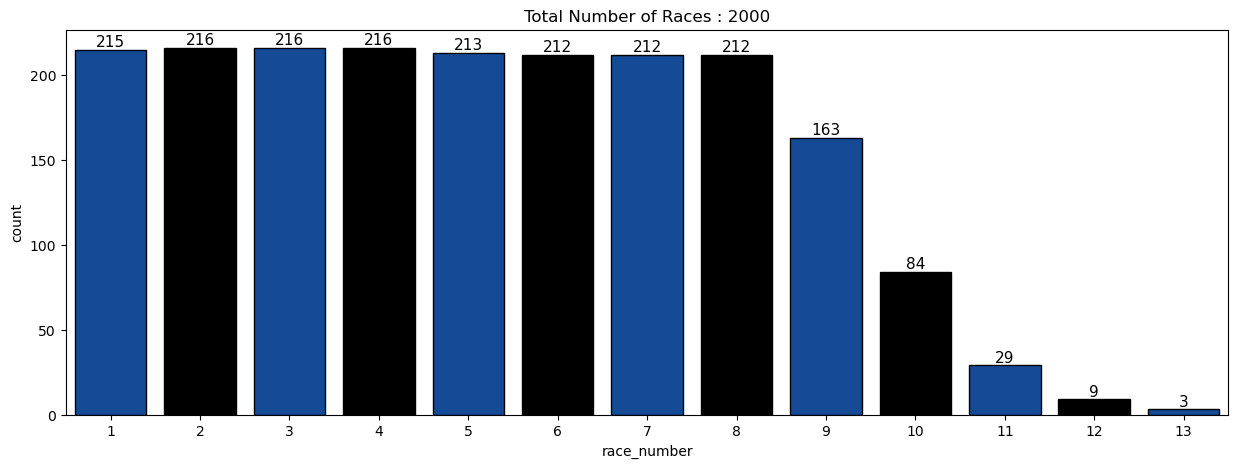

In [6]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'race_number', data = df2, palette = colors, edgecolor = 'black')
for rect in ax.patches:
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + 2,
        int(rect.get_height()),
        horizontalalignment='center',
        fontsize = 11
    )
title = 'Total Number of Races : ' + str(sum(df2['race_number'].value_counts()))
plt.title(title)

- 2000개의 경기 데이터
- 경기 번호는 1에서 13까지의 정수 값으로 라벨링 되었음
- 8번 경기(212번 진행)에서부터 마지막 13번 경기(3번 진행)까지 급격히 감소함을 보임

#### 경기장별 진행 빈도

Text(0.5, 1.0, 'Number of Races conducted on Different Racetracks')

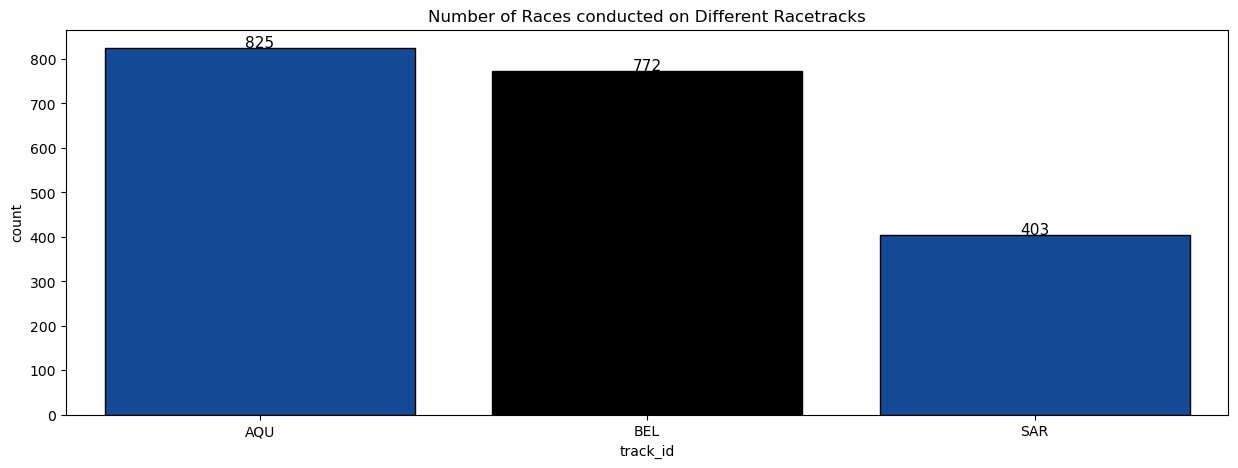

In [9]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'track_id', data = df2, palette = colors, edgecolor = 'black')
for rect in ax.patches:
    ax.text(
        rect.get_x() + rect.get_width() / 2, 
        rect.get_height() + 2, 
        int(rect.get_height()), 
        horizontalalignment='center', 
        fontsize = 11)
ax.set_xticklabels(tf2['track_id'].values())
title = 'Number of Races conducted on Different Racetracks'
plt.title(title)

- 총 3개의 경마장 진행됨:
    - AQU(Aqueduct)
    - BEL(Belmont)
- SAR(Saratoga)
- 가장 많이 개최한 경기장 : AQU(Aqueduct) / 825번
- 중간 순위 개최한 경기장 : BEL(Belmont) / 772번
- 가장 적게 개최한 경기장 : SAR(Saratoga) / 403번

#### 경기장별 진행 일정

Text(0.5, 1.0, 'Races Throughout the Year on Different Tracks')

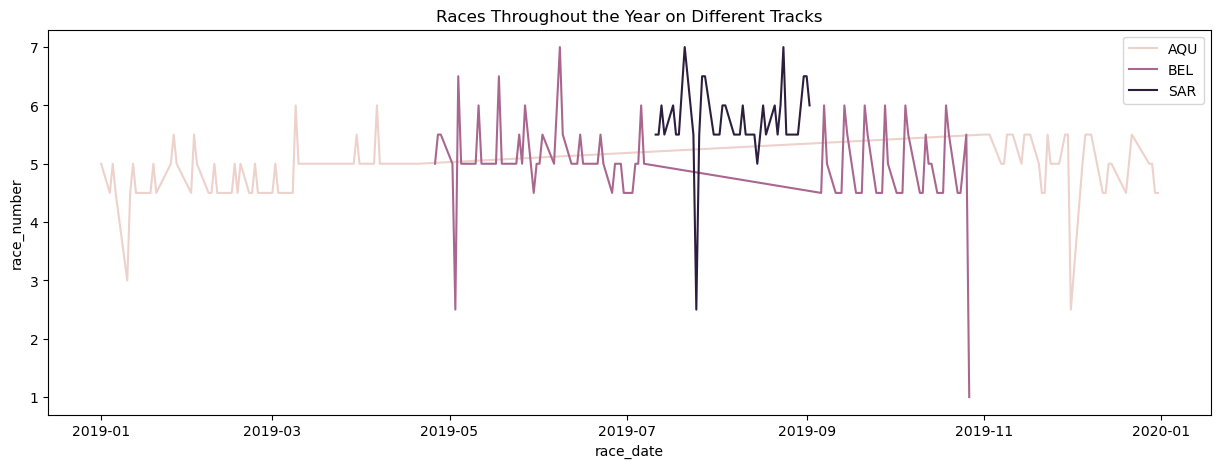

In [10]:
plt.figure(figsize = (15,5))
sns.lineplot(x = 'race_date', y = 'race_number', data = df2, hue = 'track_id', ci = None)
plt.legend(tf2['track_id'].values())
plt.title('Races Throughout the Year on Different Tracks')

- 경마 시즌은 10월 말에서 11월 초에 시작된다고 추측할 수 있음. (race_number 1이 11월달에 시작)
- AQU(Aqueduct) 경마장은 10월/11월부터 4월까지 경기를 주최 
- 그 후 2개월 동안 경기가 BEL(Belmont) 경마장에서 열리고, 이 경기는 SAR(Saratoga) 경마장에서 열리는 경기에 의해 중단됨
- BEL(Belmont) 경마장에서의 경기는 다시 9월에 시작하여 10월 말에서 11월 초까지 계속됨
- 이를 통해 **AQU(Aqueduct) 경마장에서 열리는 경기가 예선전**이어서, 이후 두 경마장에서 진행되는 토너먼트 형식의 본선으로 이어진다고 추측할 수 있음

#### 경기장의 트랙 길이

Text(0.5, 1.0, 'Distance of each Tracks')

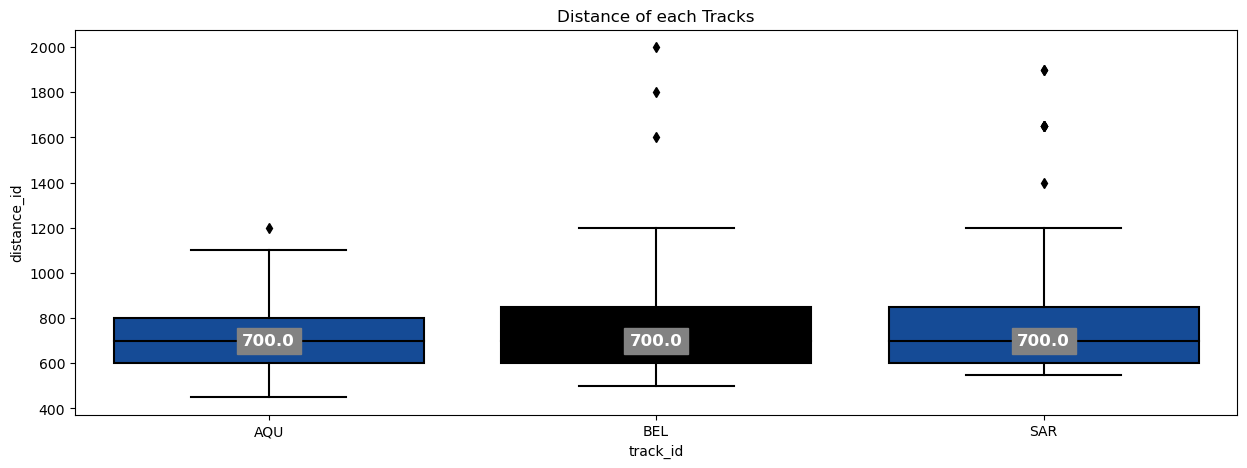

In [12]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x = 'track_id',
                 y = 'distance_id',
                 data = df2,
                 palette = colors);
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)  # <- 이 부분은 이해 못했음
    # 중앙값 텍스트로 그래프에 표시
    ax.text(cat,
            y,
            f'{y}',
            ha = 'center', va = 'center', 
            fontweight = 'semibold', size = 12, color = 'white', 
            bbox=dict(facecolor='#828282', edgecolor='#828282'))

ax.set_xticklabels(tf2['track_id'].values())
plt.title('Distance of each Tracks')

- 세 개의 경마장 모두 중앙값 거리는 700미터~7펄롱 사이
- 1400미터~14펄롱을 초과하는 이상치 값은 **BEL(Belmont)**와 SAR(Saratoga) 경마장에서 찾아볼 수 있음

#### 경기장의 트랙 상태

Text(0.5, 1.0, 'Track Conditions for the Races')

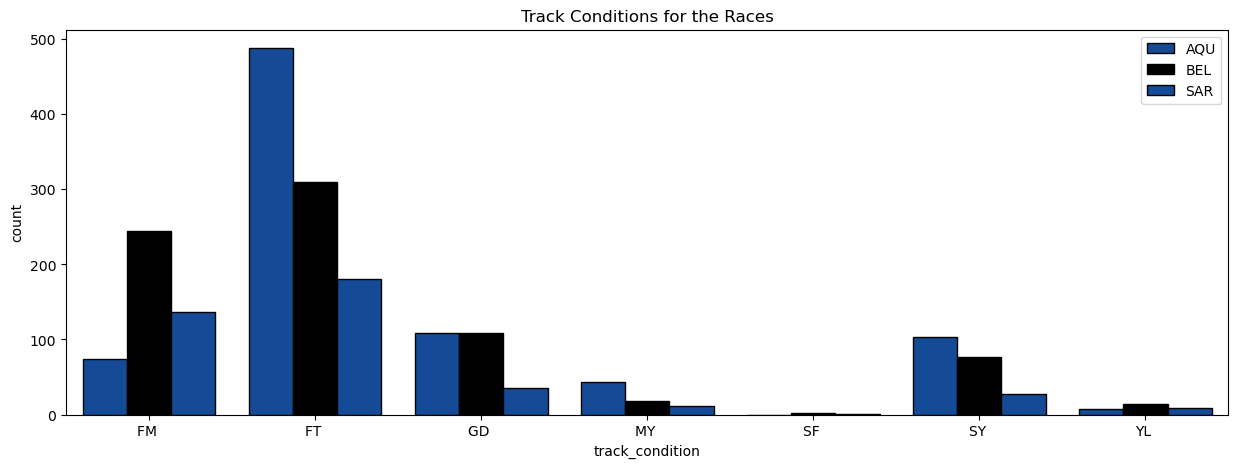

In [19]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x='track_condition', hue = 'track_id', data = df2, palette = colors, edgecolor = 'black')

# x-tick 레이블 설정
ax.set_xticklabels([tf2['track_condition'][i] for i in sorted(df2['track_condition'].unique())])

# 범례 설정
plt.legend(tf2['track_id'].values())

# 제목 설정
title = 'Track Conditions for the Races'
plt.title(title)

- 세 개의 경마장 모두 대부분의 경기는 **FT - 빠른(빠른 트랙)** 에서 진행
- BEL(Belmont) 경마장은 상당수의 경기를 **FM - 단단한(단단한 트랙)** 에서 진행
- **SF - 부드러운(부드러운 트랙)** 은 가장 적게 진행됨

#### 경기장의 게이트에서 출발 지점까지의 거리

Text(0.5, 1.0, 'Distance from Gate to the Start of the Race of the Race Tracks')

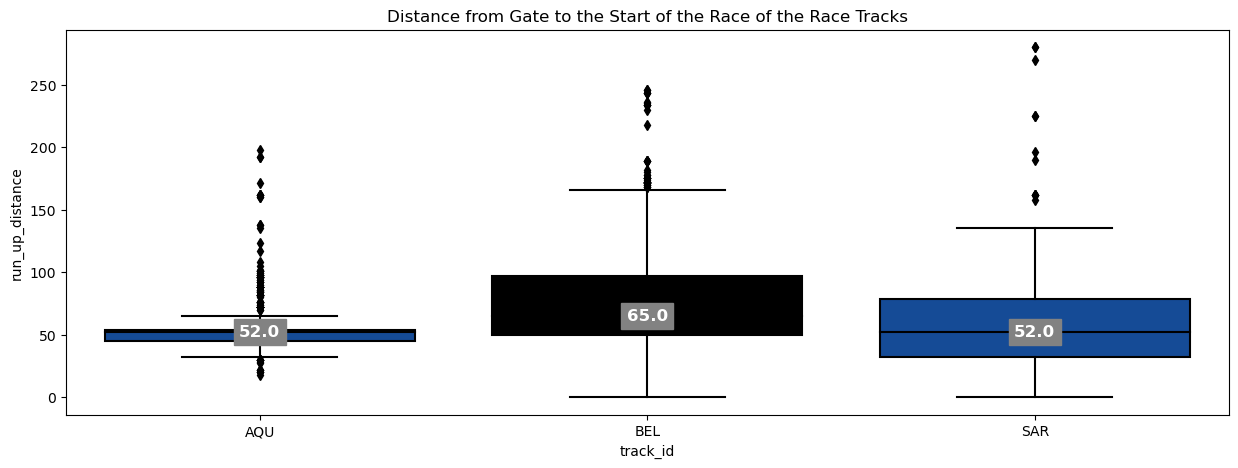

In [20]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x = 'track_id', y = 'run_up_distance', data = df2, palette = colors)
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    ax.text(cat,
            y,
            f'{y}',
            ha = 'center', va = 'center',
            fontweight = 'semibold', size = 12, color = 'white',
            bbox = dict(facecolor='#828282', edgecolor='#828282'))

ax.set_xticklabels(tf2['track_id'].values())
plt.title('Distance from Gate to the Start of the Race of the Race Tracks')

- **AQU(Aqueduct)** 와 **SAR(Saratoga)** 의 **중앙값(run-up distance)**은  동일하게 52피트
- **BEL(Belmont)** 의 run-up distance는 다른 두 경마장보다 높은 65피트
- SAR(Saratoga) 경마장에서 250피트 이상의 이상치를 포함한 가장 긴 run-up distance 값이 발견됨

#### 경기자별 진행된 경주 유형

Text(0.5, 1.0, 'Different Types of Races Conducted at Different Race Tracks')

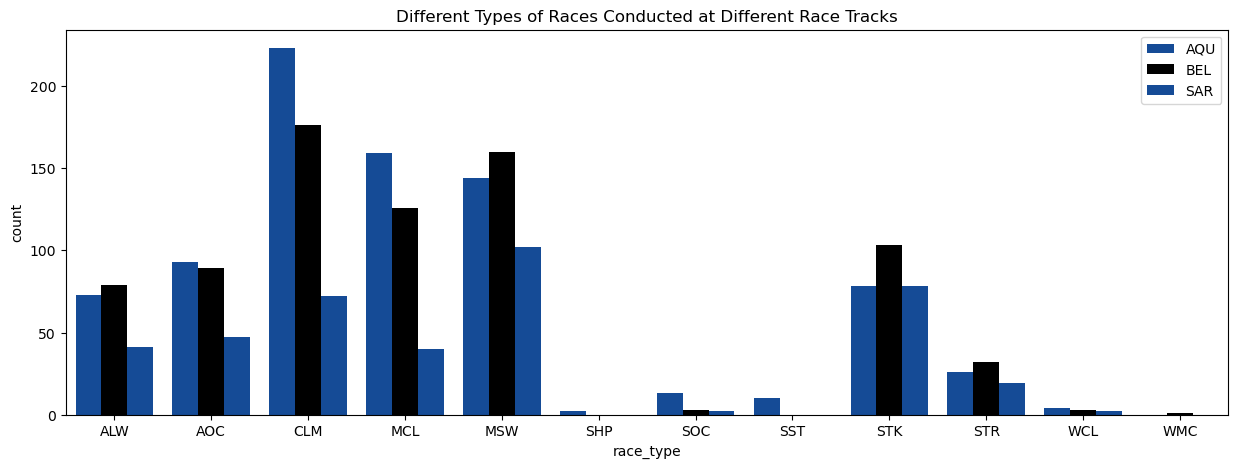

In [25]:
#race_type
#track_id

plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'race_type', hue = 'track_id', data = df2, palette = colors)
ax.set_xticklabels([tf2['race_type'][i] for i in sorted(df2['race_type'].unique())])
plt.legend(tf2['track_id'].values())
title = 'Different Types of Races Conducted at Different Race Tracks'
plt.title(title)

세 개의 경마장 모두 다음과 같은 다양한 유형의 경주들을 진행:

- ALW - Allowance
- AOC - Allowance Optional Claimer
- CLM - Claiming
- MCL - Maiden Claiming
- MSW - Maiden Special Weight
- STK - Stakes

#### 경기장별 상금

Text(0.5, 1.0, 'Purse values at Different Racetracks')

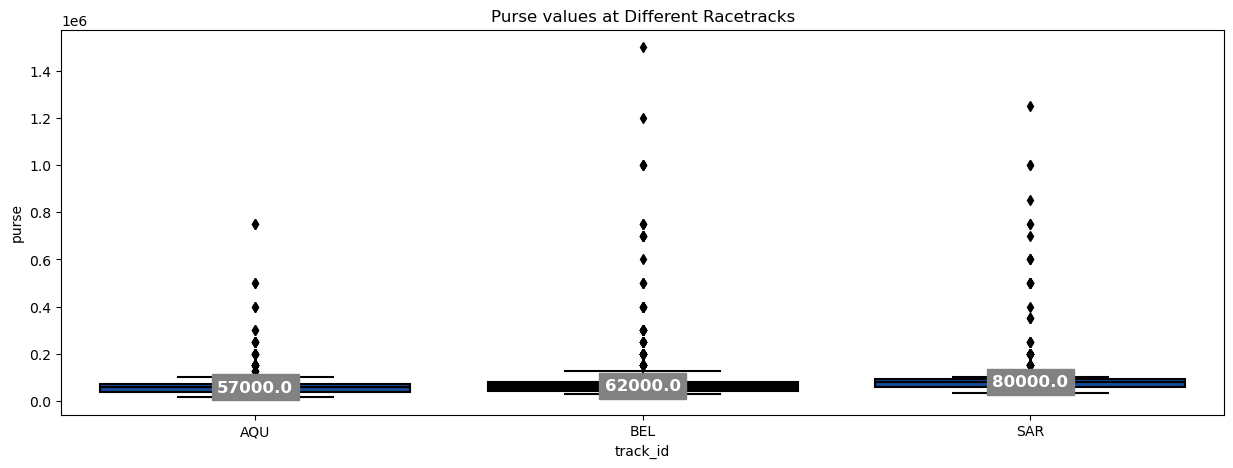

In [26]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x = 'track_id',y = 'purse',data = df2, palette = colors);
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(cat,y,f'{y}',ha='center',va='center',fontweight='semibold',size=12,color='white',bbox=dict(facecolor='#828282', edgecolor='#828282'))    
ax.set_xticklabels(tf2['track_id'].values())
plt.title('Purse values at Different Racetracks')

- **BEL(Belmont) 경마장** 의 상금 값 중 가장 높은 이상치 값은 1,400,000 이상
- **SAR(Saratoga) 경마장** 에서 진행된 경기는 적지만, 중앙값 상금이 80,000으로 다른 두 경마장보다 높음

## 5. Lesson Learned

✔️ 전반적으로 이번 EDA에서는 메모리 효율을 극대화하는 여러 방법을 엿볼 수 있었다. 

✔️ Data Type 정의 할 때, 숫자의 사이즈(가장 낮은 값, 높은 값 확인)를 고려하여 적절한 Type(int8, int16등) 선정하기 

✔️ 텍스트 변수 인코딩 해 두기 & 기존 데이터는 별도로 저장하여 매치시키기